## материалы <a name="after_link"></a>

* [Презентация](https://disk.yandex.ru/i/LjiQtk5ouv1g1g)

* [Дашборд](https://public.tableau.com/app/profile/.10443611/viz/da_23_telecom_tableau/Dashboard1?publish=yes)

>> **Телеком "Нупозвони"**

---

**поиск клиента с неоптимальными тарифами**

# ТЗ <a name="TZ"></a>

Найти клиентов, которые: 

а) переплачивают на текущих тарифах; 

б) сэкономят, если перейдут на более дорогой тариф.

предложить решение: способ уменьшения риска падения выручки, если все клиенты перейдут на более выгодные тарифы


правила формирования тарифов:

Ежемесячная плата за тариф:

- Тариф А — 5000 ₽,
- Тариф B — 2000 ₽,
- Тариф С — 1000 ₽.

**Входящие звонки** — бесплатны на всех тарифах,

**Исходящие звонки внутри сети** — бесплатны до 2000 минут в месяц на всех тарифах. Цена сверх лимита:

- A — 0.1 ₽/мин.,
- B — 0.15 ₽/мин.,
- C — 0.3 ₽/мин.

**Исходящие звонки, кроме внутренних:**

- A — 0.4 ₽/мин.,
- B — 0.5 ₽/мин.,
- C — 0.7₽/мин.

За каждого оператора клиент платит 100 ₽ в месяц на любом тарифе — дополнительно к стоимости тарифа и цене звонков.

Данный проект предназначен для сотрудников и руководства блока экономического развития (планирования). Глобальная цель- удержание (программа максимум- увеличение) кол-ва клиентов с минимальным падением выручки через создание благоприятной среды для клиентов (подбор более выгодного тарифа для клиентов- тем самым увеличение индекса лояльности клиентов и , пограмма максимум- увеличение числа клиентов (привлечение и ПЕРЕМАНИВАНИЕ новых клиентов). Расширение спектра услуг для дейтсвующих клиентов.

# вспомогательные технические ф-ции <a name="support_func"></a>

In [1]:
# пустить при необходимости
#!pip install pandas -U

In [2]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np
import math

from IPython.display import clear_output

from scipy import stats as st
from statsmodels.stats.weightstats import ztest
from scipy.stats import mannwhitneyu

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
tarif_cost = {
    'A': 5000 
    , 'B' :2000
    , 'C':1000
            }

min_over_lim_cost = {
    'A': 0.1 
    , 'B' :0.15
    , 'C':0.3
            }

out_call_cost = {
    'A': 0.4 
    , 'B' :0.5
    , 'C':0.7
            }


In [4]:
def client_sum_calculator(df , tarif_column):
  '''
подсчитывает сумму для каждого клиента в каждый месяц согласно логики подсчёта суммы в ТЗ.
подставляем сырой датафрейм и колонку с месяцем
  '''
# убираем операторов с номером 0
  df = df[ df['operator_id'] != 0 ]

  df_result= df.groupby(['user_id', 'month_count', tarif_column])['operator_id'].nunique().reset_index().rename(columns = {'operator_id' : 'operator_id_uniq_sum'})
   
  for i in tarif_cost.keys():
        df_result.loc[ df_result[tarif_column] == i , 'tarif_sum'] = tarif_cost[i]
  #df_result.loc[ df_result[tarif_column] == 'A' , 'tarif_sum'] = 5000
  #df_result.loc[ df_result[tarif_column] == 'B' , 'tarif_sum'] = 2000
  #df_result.loc[ df_result[tarif_column] == 'C' , 'tarif_sum'] = 1000

  df_result['operator_sum'] = df_result['operator_id_uniq_sum'] * 100


  df_rab = df[ df['direction']== 'out'].groupby(['user_id' , 'month_count' , 'internal', tarif_column ])['call_duration'].sum().reset_index().rename(columns= {'call_duration' : 'call_duration_sum'})  # считаем только исходящие звонки
  df_rab.loc[ df_rab['internal'] == True , 'call_duration_sum'] -= 2000*60 
  df_rab.loc[ df_rab['call_duration_sum'] < 0 , 'call_duration_sum'] = 0 # для исходящих внутрисетевыъ звонков оставилитолько кол-во платных минут
  #далее считаем сумму в усл. ед.(руб)
  
  for i in min_over_lim_cost.keys():
        df_rab.loc[ (df_rab['internal'] == True)& (df_rab[tarif_column] == i) , 'cal_internal_sum'] = df_rab['call_duration_sum'].apply(lambda x: math.ceil(x/60)* min_over_lim_cost[i] )
  #df_rab.loc[ (df_rab['internal'] == True)& (df_rab[tarif_column] == 'A') , 'cal_internal_sum'] = df_rab['call_duration_sum'].apply(lambda x: math.ceil(x/60)* 0.1 ) 
  #df_rab.loc[ (df_rab['internal'] == True)& (df_rab[tarif_column] == 'B') , 'cal_internal_sum'] = df_rab['call_duration_sum'].apply(lambda x: math.ceil(x/60)* 0.15)
  #df_rab.loc[ (df_rab['internal'] == True)& (df_rab[tarif_column] == 'C') , 'cal_internal_sum'] = df_rab['call_duration_sum'].apply(lambda x: math.ceil(x/60)* 0.3)

  for i in out_call_cost.keys():
        df_rab.loc[ (df_rab['internal'] == False)& (df_rab[tarif_column] == i) , 'cal_external_sum'] = df_rab['call_duration_sum'].apply(lambda x: math.ceil(x/60)*out_call_cost[i])
  #df_rab.loc[ (df_rab['internal'] == False)& (df_rab[tarif_column] == 'A') , 'cal_external_sum'] = df_rab['call_duration_sum'].apply(lambda x: math.ceil(x/60)*0.4)
  #df_rab.loc[ (df_rab['internal'] == False)& (df_rab[tarif_column] == 'B') , 'cal_external_sum'] = df_rab['call_duration_sum'].apply(lambda x: math.ceil(x/60)* 0.5)
  #df_rab.loc[ (df_rab['internal'] == False)& (df_rab[tarif_column] == 'C') , 'cal_external_sum'] = df_rab['call_duration_sum'].apply(lambda x: math.ceil(x/60)* 0.7)

  df_rab.fillna(0, inplace =True)
  df_rab['call_sum'] = df_rab['cal_internal_sum'] + df_rab['cal_external_sum']
  df_rab = df_rab.groupby(['user_id' , 'month_count'])['call_sum'].sum().reset_index()



  df_result = df_result.merge(df_rab, left_on=['user_id', 'month_count'], right_on=['user_id' , 'month_count'] , how='left' )
  df_result.fillna(0, inplace = True)
  df_result['total_sum'] = df_result['tarif_sum'] + df_result['operator_sum'] + df_result['call_sum']
  df_result = df_result[['user_id', tarif_column ,'month_count','tarif_sum','operator_sum','call_sum', 'total_sum']]

  #display(df_rab)
  # встроим проверку по кол-ву строк (кол-во строк (уникальных значений по client_id month  должны совпадать))
  if len(df.groupby(['user_id' , 'month_count'])['operator_id'].count().reset_index()) == len(df_result):
    print('кол-во строк исходного датасета совпадает с итоговым')
    return df_result
  else:
    print('есть проблема в калькуляторе')
    return 'error contain'

In [5]:
def active_client_detector(df):
  '''
  выделяет клиентов на последний месяц их датасета и выводит распределение по месяцам
  '''
  list_active_client= list(df[ df['month_count'] == df['month_count'].max()]['user_id'])
  df_result= df[ df['user_id'].isin(list_active_client)]
  display(df_result['month_count'].value_counts().to_frame())
  
  #df_result['month_count'].hist()

  fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5))
  ax.set_title('распределение для month_count' )
  ax.hist(df_result['month_count'])
  ax.set_xlabel('номер месяца')
  ax.set_ylabel('кол-во записей отнносящихся к актив клиентам в группе, шт.')
  ax.grid()
  #ax.legend()
  plt.xticks(rotation=-0, ha='left')
  plt.show()


  return df_result

In [6]:
def boxplot_sum_stroy(df, column_tariff,  column_month, current_month,  column_sum, title_str, log_scale = False):
  '''
  строит боксплот в разрезе тарифов на указанный месяц с лог шкалой или десятиричной шкалой
  '''  
  fig, ax = plt.subplots(figsize=(22,8))
  ax.set_title(title_str)
  ax.boxplot(
      (df[ (df[column_tariff] == 'A') & (df[column_month] == current_month)  ][column_sum]
      ,df[ (df[column_tariff] == 'B') & (df[column_month] == current_month) ][column_sum] 
      ,df[ (df[column_tariff] == 'C') & (df[column_month] == current_month)  ][column_sum]  ) 
      , vert=False
      #, labels
      ,labels  = ('A, median='+ str(round(df[ (df[column_tariff] == 'A') & (df[column_month] == current_month) ][column_sum].median() ) )
                            ,'B, median=' + str(round(df[ (df[column_tariff] == 'B') & (df[column_month] == current_month) ][column_sum].median() ) )
                            ,'C, median='  + str(round(df[ (df[column_tariff] == 'C') & (df[column_month] == current_month) ][column_sum].median() ) )
                            )
      , 
      )
  ax.set_xlabel('расходы клиентов, руб')
  ax.set_ylabel('клиент')
  ax.grid()

  if log_scale == True:
    ax.set_xscale('log') 

  plt.show()

In [7]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [8]:
def boxplot_sum_story_stroy(df, column_tariff,  column_month, tariff,  column_sum, title_str, log_scale = False):
  '''
  строит боксплот в разрезе месяцов отбора  для указанного тарифа с лог шкалой или десятиричной шкалой
  '''  
  fig, ax = plt.subplots(figsize=(22,9))
  ax.set_title(title_str)
  ax.boxplot(
      tuple(
          
        df[ (df[column_tariff] == tariff) & (df[column_month] == i)  ][column_sum] for i in df[column_month].unique()
   
      ) 
      , vert=False
      #, labels
      ,labels  = tuple(
          
          str(i) + ', median='+ str(round(df[ (df[column_tariff] == tariff) & (df[column_month] == i) ][column_sum].median() ) ) for i in df[column_month].unique() 
          
                         )
      ,
      )
  ax.set_xlabel('расходы клиентов, руб')
  ax.set_ylabel('месяц')
  ax.grid()

  if log_scale == True:
    ax.set_xscale('log') 

  plt.show()

In [9]:
def searc_optimum_tarif(df, first_tarif):
  '''
  вывод сумм для всех тарифов для каждого клиента
  на входе- оптимизированный датасет
  '''
  df_result = client_sum_calculator(df, first_tarif)
  for i in ('A','B','C'):
    df['dop_tariff'] = i
    df_result_1 = client_sum_calculator(df, 'dop_tariff').rename(columns =
        {'tarif_sum':'tarif_sum_'+i , 'operator_sum':'operator_sum_'+i 
        , 'call_sum':'call_sum_'+i , 'total_sum':'total_sum_'+i }
    )
    df_result_1.drop(columns = ['dop_tariff','month_count'], inplace=True)
    #display(df_result_1)
    #break
    df_result = df_result.merge(df_result_1, left_on='user_id', right_on='user_id' )

  df.drop(columns = ['dop_tariff'], inplace=True)

  df_result['total_sum_optimum'] = df_result[['total_sum_A','total_sum_B','total_sum_C']].min(axis = 1)
  df_result['have_optimum_tarif'] = df_result['total_sum_optimum'] - df_result['total_sum']
  df_result.loc[ df_result['have_optimum_tarif'] == 0 ,'have_optimum_tarif'] = False
  df_result.loc[ df_result['have_optimum_tarif'] < 0 , 'have_optimum_tarif'] = True

  #приведём оптимальный тариф
  df_result.loc[ (df_result['total_sum_optimum'] - df_result['total_sum_A']) == 0 , 'optimum_tarif'] ='A'
  df_result.loc[ (df_result['total_sum_optimum'] - df_result['total_sum_B']) == 0 , 'optimum_tarif'] ='B'
  df_result.loc[ (df_result['total_sum_optimum'] - df_result['total_sum_C']) == 0 , 'optimum_tarif'] ='C'

  clear_output(wait=True)

  return(df_result)

# 1) загрузка данных <a name="data_load"></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
try:
  df_client = pd.read_csv('/content/drive/MyDrive/1_telecom_clients.csv')
  df_data = pd.read_csv('/content/drive/MyDrive/1_telecom_dataset.csv')
except:
  df_client = pd.read_csv('https://.../telecom_clients.csv')
  df_data = pd.read_csv('https://.../telecom_dataset.csv')


данные загружены, можем начинать работать

# 2) предобработка данных <a name="data_preprocessing"></a>

посмотрим на загруженные таблицы:

In [12]:
display(df_client.head())
df_client.info()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


на первый взгляд- пропусков нет, тип датового столбца необходимо привести к типу даты

In [13]:
display(df_data.head())
df_data.info()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [14]:
len(df_data['operator_id'].unique())

1093

на первый взгляд в столбцах operator_id , internal есть пропуски. Так же необходимо привести типы столбцов к типу Data. Так же для уменьшения размера таблицы, можно привести столбцы direction и internal к типу bool, но т.к. таблица не сильно большая, то это не приведёт к значительному увеличению времени вычисления, а такая выгрузка может быть особенностью системы (либо надо узнать где ошибка в выгрузках (данных в базе)). На результаты это не повлияет, поэтому оставим как есть. Ту же логику применим к столбцу operator_id: на первый взгляд его надо привести к типу integer, но это для нас не принципиально и, может быть, где-то в базе есть оператор с номером 156,6, что для работы с случайной выгрузкой может нам сильно помешать при автоматическом обсчёте (имеется в виду приведение к int)

In [15]:
df_data[ (df_data['is_missed_call'] == False) & (df_data['call_duration'] == 0)].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1552,166405,2019-11-16 00:00:00+03:00,out,False,902532.0,False,1,0,27
1560,166405,2019-11-16 00:00:00+03:00,out,False,902532.0,False,1,0,27
2931,166485,2019-09-03 00:00:00+03:00,out,True,887276.0,False,1,0,4
9520,166658,2019-11-06 00:00:00+03:00,out,True,890410.0,False,1,0,0
10254,166678,2019-09-04 00:00:00+03:00,out,True,888868.0,False,1,0,5


можем обратить внимание на такой интересный момент- есть некоторое кол-во записей, у которых признак "пропущенный вызов" показывает, что звонок состаялся, но при этом "живое" время разговора составило 0 секунд. Данноя особенность могла получитсся вследствии сбоя при формировании нашего датасета либо из-за особенностей работы системы учёта времени разговоров.
В первом случай (сбой) мы должны **сообщить поставщику данных об данной проблеме** и изменить соови данные (поменять признак is_missed_call на True) или разобраться в особенностях системы учёта времени звонков и действовать по сложившейся ситуации.

Для продолжения работы мы изберём первый вариант, как наиболее реализуемый в нашей текущей ситуации: 

In [16]:
print('кол-во "ложных" признаков в is_missed_call:', len(df_data[ (df_data['is_missed_call'] == False) & (df_data['call_duration'] == 0)]))

кол-во "ложных" признаков в is_missed_call: 20


In [17]:
#заменяем "ложные" признаки
df_data.loc[ df_data['call_duration'] == 0 , 'is_missed_call'] = True

In [18]:
#print('кол-во "ложных" признаков в is_missed_call:', len(df_data[ (df_data['is_missed_call'] == False) & (df_data['call_duration'] == 0)]))

Далее начнём "причёсывать" данные

## 2.1) приведение типов данных  <a name="data_type"></a>  

приведём тип данных в солбце date_start к типу DATA в таблице df_client

In [19]:
df_client['date_start'] = df_client['date_start'].astype('datetime64')

df_client.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


приведём тип данных в солбце date к типу DATA в таблице df_data

In [20]:
df_data['date'] = pd.to_datetime(df_data['date'], utc=False)

df_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  int64                                
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          45730 non-null  float64                              
 5   is_missed_call       53902 non-null  bool                                 
 6   calls_count          53902 non-null  int64                                
 7   call_duration        53902 non-null  int64                                
 8   total_call_duration  53902 non-null  int64                                
dtypes: bool

In [21]:
#df_data.head()

типы приведены, идём дальше

## 2.2) работа с дубликатами   <a name="data_duble"></a>    

проверим таблицу df_client на дубликаты:

In [22]:
if ( df_client['user_id'].duplicated().mean() == 0 ):
  print('дубликатов не обнаружено')
else:
  print('ИМЕЮТСЯ дубликаты')

дубликатов не обнаружено


проверим таблицу df_data на дубликаты:

In [23]:
if ( df_data.duplicated().mean() == 0 ):
  print('дубликатов не обнаружено')
else:
  print('ИМЕЮТСЯ дубликаты!')



ИМЕЮТСЯ дубликаты!


выведем дубликаты:

In [24]:
df_data[df_data.duplicated() ].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
44,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
51,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,1413,1473


Учитывая тот факт, что данные нам приходят в приведённом виде (проссумированные по дню для каждого набора параметров), то, теоритически, дубликатов быть не должно. Появлению дубликатов моут способствовать следующие причины:

* технический сбой при поставке данных либо сбой в системе хранения "сырых" данных (например данные поставляются из нескольких баз: соответсвенно проверку на совпадения они не проходят и записываются поставщиком данных для нас как две строки). В данном случае мы находимся на распутье и надо узнавать информацию у поставщика данных. В первом случае (технический сбой припоставке данных) мы должны **сообщить поставщику о сбое в поставке данных для проведения ремонта системы** и удалить дубликаты (исключая дубликаты из следующего абзаца). Если же данные "тянутся" из разных баз и не проводится проверка на совпадение, то мы должны проссумировать данные и сообщить поставщику данных об этом недочёте. 

Для продолжения работы мы выберем первый вариант решения проблемы

* в связи с неполной заполненностью столбцов  internal и operator_id дубликаты могут появляться из-за неопределённости параметров. С данными дубликатами мы будем бороться путём заполнения отсутствующих значений (там где это возможно). В случаях, если это не поможет, то мы примем решение из предыдущего абзаца. Действия, описанные в данном абзаце выполнем в п.2.2


In [25]:
print('число дубликатов:', len(df_data[df_data.duplicated() ]), 
      ', что составляет', round(100*len(df_data[df_data.duplicated() ])/len(df_data), 1), '% от всех данных'   )
print('среди них:')
print('кол-во строк с отсутствием значений в столбце internal:', len(df_data[df_data.duplicated() &  df_data['internal'].isna() ]))
print('кол-во строк с отсутствием значений в столбце operator_id:', len( df_data[df_data.duplicated() &  df_data['operator_id'].isna() ] ) )

print('доля клиентов, данные которых имеют дубликаты:',
      round( 100*df_data[df_data.duplicated() ].user_id.nunique() / len(df_client) ,1) , ' %')

число дубликатов: 4900 , что составляет 9.1 % от всех данных
среди них:
кол-во строк с отсутствием значений в столбце internal: 7
кол-во строк с отсутствием значений в столбце operator_id: 716
доля клиентов, данные которых имеют дубликаты: 36.7  %


как можем увидеть что доля дубликатов имеет значительное кол-во. Треть клиентов "подверглись" дублированию. Но, согласно принятому выше решению будем избавляться от "истинных" дубликатов

In [26]:

df_data = df_data[ ~df_data.isin( 
    df_data[df_data.duplicated() & ~df_data['internal'].isna() &  ~df_data['operator_id'].isna()] )['user_id'] ]

#len(df_data)

In [27]:
#len(df_data)

In [28]:
print('ИТОГО, осталось дубликатов:', df_data[df_data.duplicated() ]['user_id'].count() ,' шт.\nс ними будем бороться в следующем пункте (продолжение следует...)' )

ИТОГО, осталось дубликатов: 721  шт.
с ними будем бороться в следующем пункте (продолжение следует...)


## 2.3) работа с пропусками и удаление остаточных дубликатов   <a name="data_pass"></a>    



In [29]:
print('доля пропусков в датасете df_client:')
df_client.isna().mean()

доля пропусков в датасете df_client:


user_id        0.0
tariff_plan    0.0
date_start     0.0
dtype: float64

In [30]:
print('доля пропусков в датасете df_data:')
df_data.isna().mean()

доля пропусков в датасете df_data:


user_id                0.000000
date                   0.000000
direction              0.000000
internal               0.002353
operator_id            0.164351
is_missed_call         0.000000
calls_count            0.000000
call_duration          0.000000
total_call_duration    0.000000
dtype: float64

имеем пропуски в internal и в operator_id. Выведем их. Начнём с internal:

In [31]:
print('кол-во пропусков в столбце internal:' , df_data[df_data['internal'].isna()].user_id.count() )

кол-во пропусков в столбце internal: 117


востанавливать пропущенные значения будем руководствуясь следующей логикой: каждая строка должна иметь уникальный набор состоящий из следующих параметров user_id` `date` `direction` `internal` `operator_id` `is_missed_call. Соответсвенно, если мы будем сравнивать параметры строки с пропуском и других строк с похожими идетнификаторами, то мы сожем установить верное значение пропуска

Важно: если будет пропуск более чем в одном столбце, то мы не сможем востановить данные руководствуясь данной логикой

логика отбора: находим все строки с одинаковыми наборами параметров user_id , date и operator_id. Кол-во строк не может привышать произведения вариативности параметров в direction , internal , is_missed_call - что составляет 2 * 2 * 2 = 8 шт. Соответсвенно, внутри подгруппы однотипных internal не может быть больше 4 значений (8шт / 2). Следовательно если мы видим 4 шт internal с одним параметром, то наша строка с отсутствующим параметрам равна другому параметру

In [32]:
print('кол-во строк, удовлетворяющих условия (только один пропуск в строке):' , len(df_data[(df_data['internal'].isna()) & (~df_data['operator_id'].isna()) ]))

кол-во строк, удовлетворяющих условия (только один пропуск в строке): 60


In [33]:
for index, row in df_data[(df_data['internal'].isna()) & (~df_data['operator_id'].isna()) ].iterrows(): # получаем строки с потенциалом к востановлению
    
    df_rab = df_data[ (df_data['user_id'] == row['user_id']) & (df_data['date'] == row['date']) & (df_data['operator_id'] == row['operator_id']) ] # находим подвыборку
    # далее ищем было ли 4 строки с одинаковым internal и присваваем нашему пустому значению противоположное значение
    #print(df_rab['internal'].value_counts().to_frame().reset_index())
    
    #далее идёт конструкция с учёто граничных значений (наличие 0 строки и 1 строки в df_rab['internal'].value_counts().to_frame())
    if len(df_rab['internal'].value_counts().to_frame().reset_index()) > 0:
      if (df_rab['internal'].value_counts().to_frame().reset_index().iloc[0, 1] > 3):
        #print('asd',df_data.iloc[index, :])
        a = not df_rab['internal'].value_counts().to_frame().reset_index().iloc[0, 0]
        df_data.loc[df_data.index==index, 'internal'] = a
        #print(a)
        
      elif len(df_rab['internal'].value_counts().to_frame().reset_index()) > 1:
        if (df_rab['internal'].value_counts().to_frame().reset_index().iloc[1, 1] > 3):
          a = not df_rab['internal'].value_counts().to_frame().reset_index().iloc[1, 0]
          df_data.loc[df_data.index==index, 'internal'] = a
          #print(a)
       
    #print(df_rab['internal'].value_counts().to_frame().reset_index())
    #print(df_rab['internal'].value_counts().to_frame().reset_index().iloc[0, 1])
    #print(not df_rab['internal'].value_counts().to_frame().reset_index().iloc[0, 0])
    
    #break

In [34]:
print('кол-во строк, удовлетворяющих условия (только один пропуск в строке) после автоматической обработки:' , len(df_data[(df_data['internal'].isna()) & (~df_data['operator_id'].isna()) ]))

кол-во строк, удовлетворяющих условия (только один пропуск в строке) после автоматической обработки: 54


с точки зрения подсчёта деежных сумм- нас интересуют только строки с исходящими звонками (direction = out). Посмотрим на распределение пропусков по этому признаку:

In [35]:
df_data[df_data['internal'].isna()]['direction'].value_counts()

in     109
out      2
Name: direction, dtype: int64

как можем увидеть- только 2 значения пропуска в internal по пали в исходящие звонки- посмотрим на них:

In [36]:
df_data[(df_data['internal'].isna()) & (df_data['direction'] == 'out')]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
21004,167016,2019-10-23 00:00:00+03:00,out,NaN,NaN,True,3,0,196
51367,168291,2019-11-28 00:00:00+03:00,out,NaN,NaN,True,3,0,93


как можно увидеть- общего у этих строк не много (кроме как пропуски в 2-ух столбцах). Но они оба пропущены, а ,поскольку, пропущенные вызовы не оплачиваются- то в экономические выкладки они не попадут. Оставляем "как есть"

---
поработаем с operator_id:

In [37]:
print('кол-во пропущенных значений:' , df_data[df_data['operator_id'].isna()]['user_id'].count())

кол-во пропущенных значений: 8172


In [38]:
df_data[df_data['operator_id'].isna()]['direction'].value_counts()

in     7972
out     200
Name: direction, dtype: int64

как можем увидеть- большинство строк с пропущеными значениями в operator_id - входящие, соответсвенно они мало влияют на итоговый расчёт сумм для клиента (все входящия бесплатны)

In [39]:
df_data[df_data['operator_id'].isna()][['direction','internal']].value_counts()

direction  internal
in         False       7603
           True         314
out        False        157
           True          41
dtype: int64

In [40]:
(df_data[df_data['operator_id'].isna()]['date'].min() , df_data[df_data['operator_id'].isna()]['date'].max())

(Timestamp('2019-08-02 00:00:00+0300', tz='pytz.FixedOffset(180)'),
 Timestamp('2019-11-28 00:00:00+0300', tz='pytz.FixedOffset(180)'))

как можем увидеть, у пропущенных операторов привалируют входящие пропущенные звонки. Строки с такими операторами появляются во всех временах нашей выборки. Можем предположить, что оператор № NaN это оператор, имя которого состоит не только из чисел, что в свою очередь при сборе данных не смогло уложиться в тип чисел с плавающей точкой. Поэтому можем принять его за отдельного оператора и присвоим ему номер 0. С другой стороны у нас около 1000 операторов, а данный "0" оператор "отжирает" 16% всех строк - а это очень много. Поэтому, руководствуясь консервативным подходом, оставим данное значение (0) в качестве рабочей записи как "неидентефицированный оператор" и будем надеяться, что нам починят сборщик данных.

In [41]:
df_data['operator_id'].fillna(0, inplace = True)

---
С точки зрения неискажения данных- оставим остаточные дубликаты (см п 2.2) , образованные вследствии применения методов востановления данных из этого пункта, поскольку данные востановлены только в "техническом" смысле и мы не уверены в истинности дубликатов.

---
итоговое кол-во необработанных пропусков:

In [42]:
print('доля пропусков в датасете df_data:')
df_data.isna().mean()

доля пропусков в датасете df_data:


user_id                0.000000
date                   0.000000
direction              0.000000
internal               0.002232
operator_id            0.000000
is_missed_call         0.000000
calls_count            0.000000
call_duration          0.000000
total_call_duration    0.000000
dtype: float64

поработали с пропусками- идём дальше

## 2.4) работа с выбросами  и аномальным поведением   <a name="data_anomal"></a>    




In [43]:
print('кол-во уникальных user_id в таблице client:' , df_client['user_id'].nunique())
print('кол-во уникальных user_id в таблице data:' , df_data['user_id'].nunique())

кол-во уникальных user_id в таблице client: 732
кол-во уникальных user_id в таблице data: 307


видим, что уникальных клиентов в таблице "клиенты" больше- вероятно нам скинули всю базу клиентов, но не все клиенты учавствовали в звонках (покупках) в отчётный период- проверим это:

In [44]:
count_ancoincidences = 0
for i in df_data['user_id'].unique():
  if i not in df_client['user_id'].unique():
   count_ancoincidences +=1

if count_ancoincidences > 0:
  print('в таблице data имеются клиенты, без обозначения в таблице client')
else:
  print('все клиенты в data описаны в client')

все клиенты в data описаны в client


поработаем с таблицей df_client:

проверим на уникальность столбцы tariff_plan и крайние даты столбца date_start

In [45]:
df_client['tariff_plan'].unique()

array(['A', 'C', 'B'], dtype=object)

In [46]:
(df_client['date_start'].min()  , df_client['date_start'].max()  )

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-10-31 00:00:00'))

поработаем с user_id:

In [47]:
print('кол-во клиентов' , df_client['user_id'].nunique(), 'неожиданных значений нет')

кол-во клиентов 732 неожиданных значений нет


In [48]:
print('кол-во уникальных групп для каждого клиента:' ,df_client.groupby('user_id')['tariff_plan'].count().max() )

кол-во уникальных групп для каждого клиента: 1


для таблицы Client всё хорошо. поработаем с таблицей data

In [49]:
(df_data['date'].min()  , df_data['date'].max()  )

(Timestamp('2019-08-02 00:00:00+0300', tz='pytz.FixedOffset(180)'),
 Timestamp('2019-11-28 00:00:00+0300', tz='pytz.FixedOffset(180)'))

In [50]:
print('уникальные значения:')
print('direction:' , df_data['direction'].unique())
print('internal:' , df_data['internal'].unique())
print('is_missed_call:' , df_data['is_missed_call'].unique())

уникальные значения:
direction: ['in' 'out']
internal: [False True nan]
is_missed_call: [ True False]


неожиданных отклонений не наблюдается

In [51]:
(df_data['calls_count'].min()  , df_data['calls_count'].max()  )

(1, 4817)

In [52]:
(df_data['call_duration'].min()  , df_data['call_duration'].max()  )

(0, 144395)

In [53]:
(df_data['total_call_duration'].min()  , df_data['total_call_duration'].max()  )

(0, 166155)

аномальных значений не увидели

In [54]:
#df_data.head()

посмотрим на максимальное время разговора операторов 

In [55]:
aa = (
    df_data[ df_data['operator_id'] != 0 ].groupby(['operator_id' , 'date']).agg({'call_duration': 'sum', 'total_call_duration' : 'sum'}).reset_index()
    #.call_duration.max() 
)

aa['call_duration'] = aa['call_duration'].agg(lambda x: x/(60*60))
aa['total_call_duration'] = aa['total_call_duration'].agg(lambda x: x/(60*60))

aa = aa[ aa['call_duration'] > 24 ]

print('кол-во операторов с временем разговора более 24 ч:', len(aa) , '\nкол-во операторов: ', aa['operator_id'].nunique())
aa
#aa[ aa['call_duration'] == aa['call_duration'].max() ]

кол-во операторов с временем разговора более 24 ч: 23 
кол-во операторов:  1


,operator_id,date,call_duration,total_call_duration
824,885876.0,2019-09-02 00:00:00+03:00,25.401944,35.115556
825,885876.0,2019-09-03 00:00:00+03:00,24.641667,36.876944
826,885876.0,2019-09-04 00:00:00+03:00,26.126389,35.200833
827,885876.0,2019-09-05 00:00:00+03:00,30.918611,37.676389
828,885876.0,2019-09-06 00:00:00+03:00,24.871944,31.911389
831,885876.0,2019-09-09 00:00:00+03:00,34.033611,44.673889
833,885876.0,2019-09-11 00:00:00+03:00,32.139444,41.503889
834,885876.0,2019-09-12 00:00:00+03:00,35.198889,42.720278
835,885876.0,2019-09-13 00:00:00+03:00,27.748056,35.411667
839,885876.0,2019-09-17 00:00:00+03:00,28.100833,41.801667


как можем увидеть- все превышения происходят у одного оператора и приблизительно в 1 месяц. Возможно в этот период у данного оператора была тех проблема (но это маловероятно). Очень правдоподобно выглядит такая версия: данный оператор ушёл в отпуск и АТС настроили на переадресацию вызовов. Настройка предполагала, что звонок идёт одновременно у 2-ух операторов, поэтому было задвоение времени.

либо был тех сбой. Для продолжения работ выберем первый вариант

In [56]:
#df_data.head(2)

посмотрим на кол-во звонков в день:

In [57]:
bb = (
    df_data[ df_data['operator_id'] != 0 ].groupby(['operator_id' , 'date']).agg({'calls_count': 'sum'}).reset_index()
    #.call_duration.max() 
    .sort_values('calls_count', ascending = False)
)

#bb = bb[ aa['call_duration'] > 24 ]
bb['sec_per_call'] = 24*60*60/bb['calls_count']
bb.sort_values('sec_per_call', ascending = True)

,operator_id,date,calls_count,sec_per_call
13774,929428.0,2019-11-11 00:00:00+03:00,5022,17.204301
853,885876.0,2019-10-01 00:00:00+03:00,2767,31.225154
13767,929428.0,2019-10-31 00:00:00+03:00,2730,31.648352
846,885876.0,2019-09-24 00:00:00+03:00,2325,37.161290
839,885876.0,2019-09-17 00:00:00+03:00,2206,39.165911
...,...,...,...,...
8646,908180.0,2019-09-10 00:00:00+03:00,1,86400.000000
8644,908162.0,2019-09-29 00:00:00+03:00,1,86400.000000
8641,908152.0,2019-10-07 00:00:00+03:00,1,86400.000000
8640,908152.0,2019-09-25 00:00:00+03:00,1,86400.000000


как можем увидеть, есть дни и операторы,  у которых при равномерной работе в сутки время разоговор порядка нескольких десятков секунд. Данный факт может объясняться либо установкой на номер этого оператора автоответчика либо тестирование через него робота. Впринципе нам это не мешает, но может противоречить условиям договора между провайдером и клиентом. Так же на данных номерах может стоять кака-нибудь служебная система передачи данных

In [58]:
if (df_data['total_call_duration'] - df_data['call_duration']).min() < 0:
  print('встречаются строки, где суммарное время меньше "живого" времени')
else:
  print('"живое" время всегда меньше или равно общему времени (живое время + время ожидания)')

"живое" время всегда меньше или равно общему времени (живое время + время ожидания)


посмотрели на крайние значения в таблицах выбросов или неожиданных значений не обнаружили. можем продолжать работать

##2.5) расчёт стоимости каждого месяца для клиентов   <a name="client_revenue"></a>    


т.к. абонентская плата снимается 1 раз в месяц- то отчётный период будем брать в 1 месяц. А т.к. по условиям задачи- начало отчётного периода- 1 число каждого месяца. Выделим номер месяца и год для каждой строчки данных

In [59]:
df_data['month_count'] = df_data['date'].dt.month

соединим дветаблицы для более удобной работы

In [60]:
df_full_data = df_data.merge(df_client, left_on='user_id', right_on='user_id' )
#df_full_data.sample(3)

найдём сумму покаждому клиенту

In [61]:
df_client_sum = client_sum_calculator(df_full_data , 'tariff_plan')
df_client_sum.head()
#df_full_data

кол-во строк исходного датасета совпадает с итоговым


,user_id,tariff_plan,month_count,tarif_sum,operator_sum,call_sum,total_sum
0,166377,B,8,2000.0,500,541.5,3041.5
1,166377,B,9,2000.0,400,713.5,3113.5
2,166377,B,10,2000.0,500,680.0,3180.0
3,166377,B,11,2000.0,400,652.5,3052.5
4,166391,C,8,1000.0,200,0.0,1200.0


получили сумму для каждого клиента в каждоммесяце. Можем продолжить работать


# 3) исследовательский анализ данных   <a name="data_reserch"></a>    




отталкиваться будем от таблицы df_client_sum  и функции client_sum_calculator

## 3.1) отделение неактивных клиентов   <a name="client_passive"></a>

отделять клиентов будем по последнему месяцу (если есть покупки (звонки) в последнем месяце (11), то оставляем этих клиентов. Это те клиенты, которым мы делаем сервис для удержания и рекламы для новых.


,month_count
11,245
10,204
9,118
8,48


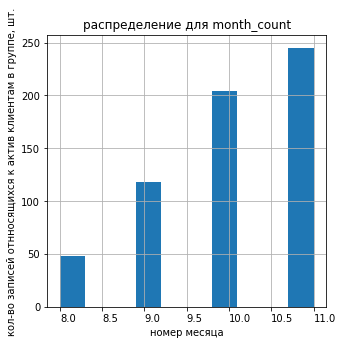

In [62]:
df_active_client_sum = active_client_detector(df_client_sum)

получили таблицу с ценами для активных на 11 месяц клиентов. Как можно увидеть не все активные на сегодняшний день клиенты были с нами с начала отчётного периода

так же создадим полную таблицу только по активным клиентам

,month_count
11,21823
10,15808
9,7052
8,1723


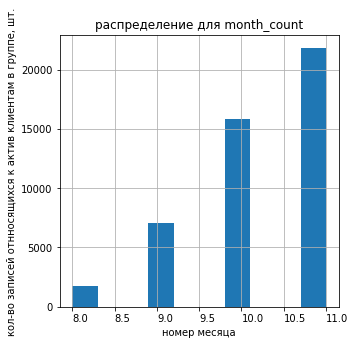

In [63]:
df_full_data_active_client = active_client_detector(df_full_data)

видем рост кол-ва операций активными (на последний месяц) клиентами (вероятней всего это связано с увеличением числа клиентов)

## 3.2) распределение и средний доход по группам, динамика изменения дохода   <a name="group_revenue"></a>

In [64]:
#df_active_client_sum

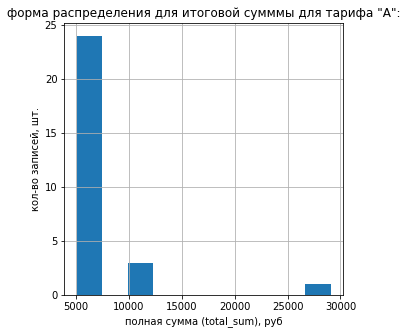

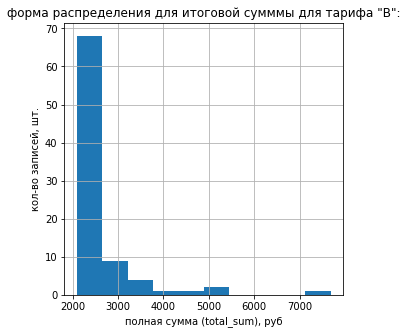

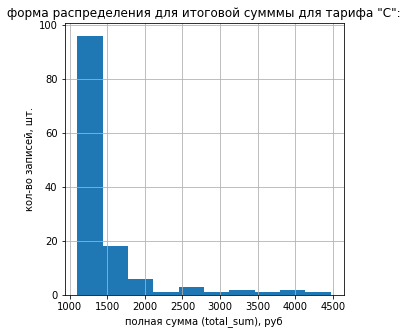

In [65]:
for i in ('A', 'B', 'C'):
  #print('форма распределения для итоговой сумммы для тарифа "{}":'.format(i))

  fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5))
  ax.set_title('форма распределения для итоговой сумммы для тарифа "{}":'.format(i) )
  ax.hist(df_active_client_sum[ (df_active_client_sum['tariff_plan'] == i) & (df_active_client_sum['month_count'] == 11) ]['total_sum'])
  ax.set_xlabel('полная сумма (total_sum), руб')
  ax.set_ylabel('кол-во записей, шт.')
  ax.grid()

  #df_active_client_sum[ (df_active_client_sum['tariff_plan'] == i) & (df_active_client_sum['month_count'] == 11) ]['total_sum'].hist()
  plt.show()

т.к. форма распределения далека от нормальной, то мерой среднего значения будем считать медианное значение

Построим распределения доходов:

в связи с тем, что есть большие выбросы- вывод сделаем в логарифмической шкале 

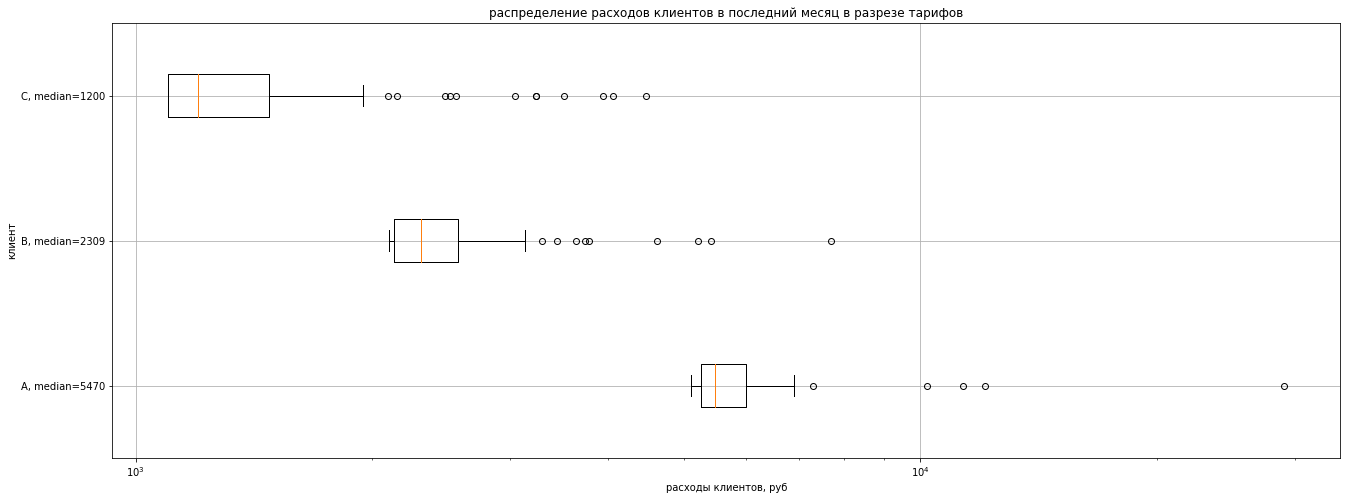

In [66]:
boxplot_sum_stroy(df_active_client_sum , 'tariff_plan' , 'month_count'
                  , df_active_client_sum['month_count'].max() , 'total_sum' 
                  ,  'распределение расходов клиентов в последний месяц в разрезе тарифов', log_scale =True)

посмортим динамику изменения суммарного дохода по месяцам в разрезе групп:

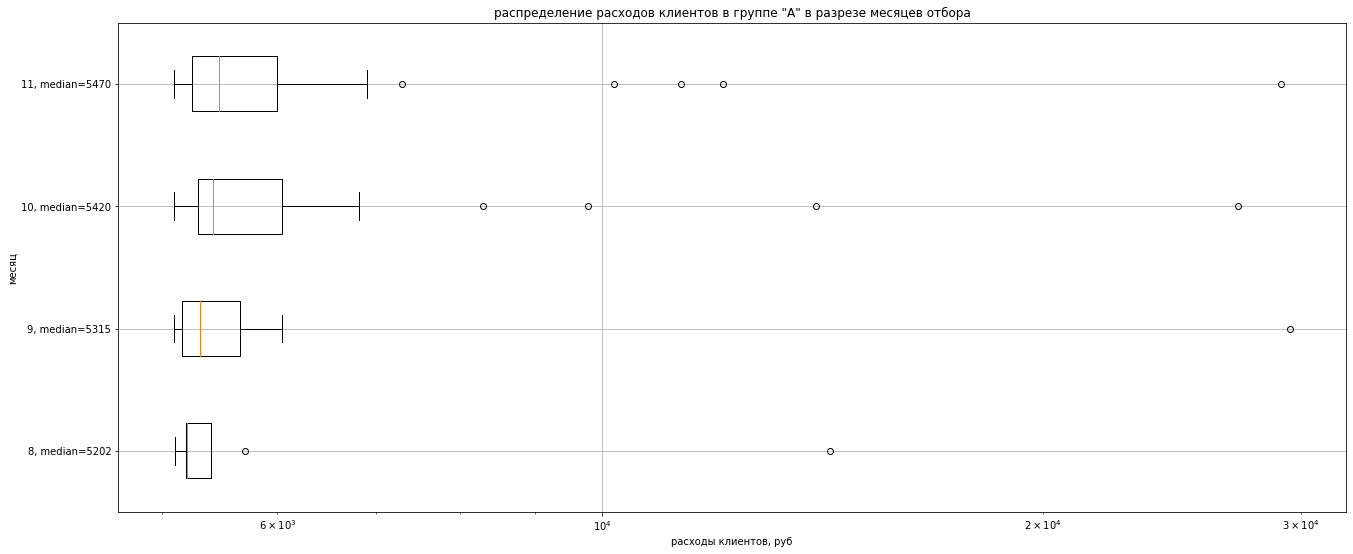

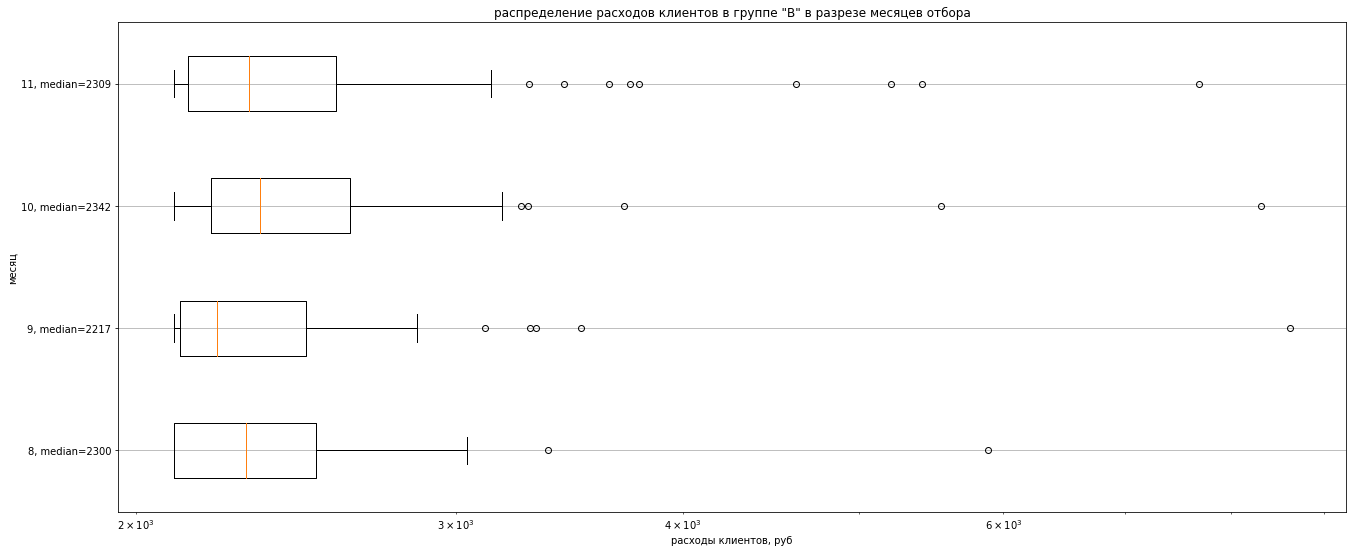

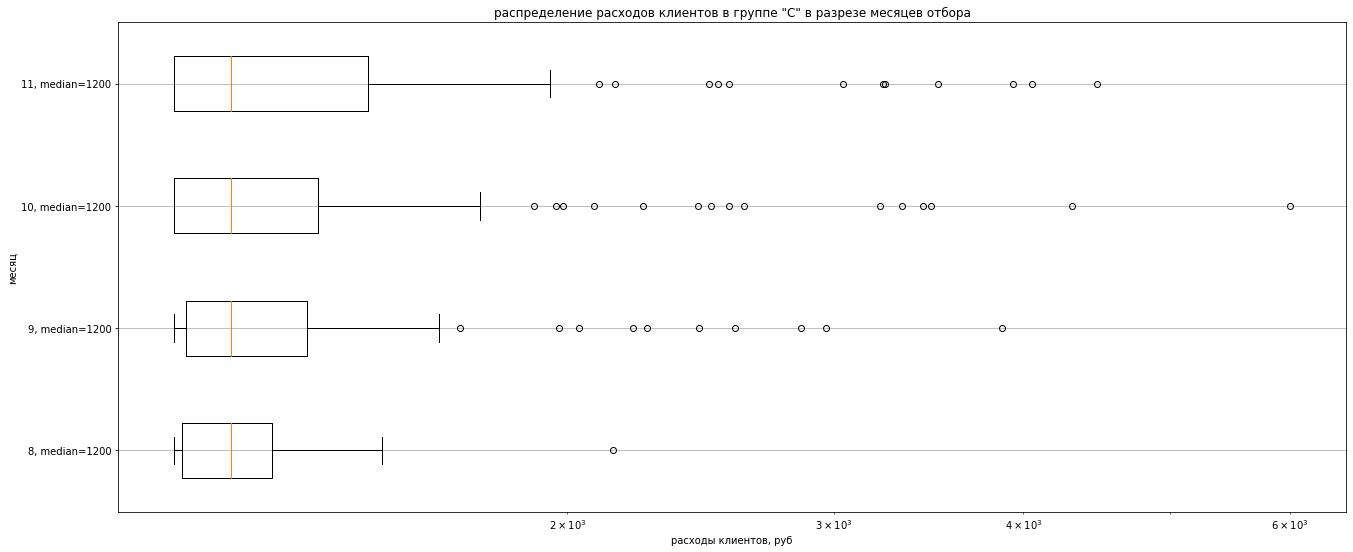

In [67]:
for i in ('A', 'B','C'):
  boxplot_sum_story_stroy(df_active_client_sum , 'tariff_plan' , 'month_count'
                  , i, 'total_sum' 
                  ,  'распределение расходов клиентов в группе "' + str(i) +'" в разрезе месяцев отбора', log_scale =True)

На графике можем наблюдать, что для самой высокооплачиваемой группы "С" средний доход по месяцам стабилен (что может говорить о правильном подборе и грамотном распределении расходов у клиентов данной группы). В менее тарифо-нагруженном тарифе "В" картина похожа . В группе "А"  средний доход сильно отличается от месяца к месяцу, что может говорить или о низкой культуре отбора трат у клиентов либо об их росте и бурном развитии (что, потенциально даёт на желание удержать данных клиентов для будущих больших зароботков в случае их экспанентциального роста)



In [68]:
a=df_active_client_sum[ df_active_client_sum['month_count'] == 11 ].groupby('tariff_plan')[['total_sum' , 'tarif_sum', 'operator_sum', 'call_sum']].median()
b=df_full_data_active_client[ df_full_data_active_client['month_count'] == 11 ].groupby('tariff_plan')['call_duration'].median().to_frame()


df_rab_rab = a.join(b)
df_rab_rab['rub/min'] = df_rab_rab['total_sum'] / df_rab_rab['call_duration']
df_rab_rab[['rub/min' , 'tarif_sum', 'operator_sum', 'call_sum']]

,rub/min,tarif_sum,operator_sum,call_sum
tariff_plan,,,,
A,66.709756,5000.0,250,120.20
B,49.661290,2000.0,200,17.75
C,40.000000,1000.0,100,1.40


На таблице представлена средняя (медианна) полная стоимость минуты в 11 месяце в разрезе тарифов- больше всех платят клиенты группы "А"

Таким образом можно сделать предположение, что клиенты с тарифом "С" - устаявшиеся крупные игроки рынка, а клиенты с тарифом "А" - новички рынка, с возможным потенциалом роста.

Так же, можем сказать, что клиенты из группы "А", в среднем" тратят больше всех, что даёт поле деятельности по работе с данными клиентами

In [69]:
#df_active_client_sum.sample(5)

Добаваил в таблицу медианные суммы за тариф, операторов и сверхлимитные звонки

In [70]:
df_rab_rab[['rub/min' , 'tarif_sum', 'operator_sum', 'call_sum']]

,rub/min,tarif_sum,operator_sum,call_sum
tariff_plan,,,,
A,66.709756,5000.0,250,120.20
B,49.661290,2000.0,200,17.75
C,40.000000,1000.0,100,1.40


Клиенты с тарифом "А" платят больше в основном из-за большой суммы тарифа, при этом они больше доплачивают за сверх звонки и используют в своём штате больше операторов

##3.3) соотношение численностей групп   <a name="group_count"></a>


посмотрим на распределение всех клиентов по месяцам:

In [71]:
df_full_data.groupby(['month_count','tariff_plan'])['user_id'].nunique().to_frame()

user_id
month_count tariff_plan         
8           A                 11
            B                 35
            C                 39
9           A                 19
            B                 66
            C                 88
10          A                 33
            B                 92
            C                148
11          A                 30
            B                 96
            C                135

можем увидеть как из месяца в месяц растёт число активных клиентов и устанавливается к октябрю. Среди клиентов привалирует тариф "С", и соотношение между тарифами так же остаётся постоянным, что может свидетельствовать либо об постоянном притоке и оттоке клиентов (равномерном), либо о неразвитии клиентов (при увеличении уровня клиентов- повышается его потребность в услугах- переходит на более выгодный для него тариф)

## 3.4) соотношения видов звонков по группам (входящий, исходящий, внутренний, внешний)   <a name="group_revenue"></a>



смотреть динамику не будем, т.к. нас интересует только последний месяц и меры по удержанию клиентов и выручки. Так же в этом месяце больше всего клиентов. Динамику изменения, при необходимости, можно посмотреть в отдельном исследовании

In [72]:
for i in ('in', 'out'):
  for k in (True, False):
    print('\n\nтаблица динамики для direction = {} и internal = {}'.format(i,k))
    df_rab_11 = df_full_data_active_client[ (df_full_data_active_client['direction'] == i) & (df_full_data_active_client['internal'] == k) & (df_full_data_active_client['month_count'] == df_full_data_active_client['month_count'].max()) ].groupby(['month_count','tariff_plan', 'user_id']).agg({'call_duration':'sum' }).reset_index()
    display(
        df_rab_11.groupby(['month_count','tariff_plan']).agg({'call_duration':'median' })
    )

    



таблица динамики для direction = in и internal = True


call_duration
month_count tariff_plan               
11          A                   2230.0
            B                      3.5
            C                     10.0



таблица динамики для direction = in и internal = False


call_duration
month_count tariff_plan               
11          A                   7980.5
            B                    894.0
            C                   1501.5



таблица динамики для direction = out и internal = True


call_duration
month_count tariff_plan               
11          A                    578.0
            B                      3.5
            C                      0.0



таблица динамики для direction = out и internal = False


call_duration
month_count tariff_plan               
11          A                  22185.5
            B                   8054.5
            C                   6972.5

Как мы можем увидеть- с точки зрения среднего значения (мера- медиана) клиенты с тарифом "В" и "С" мало отличаются друг от друга. Клиенты с тарифом "А" ползуются звонками сильно больше своих "коллег". А учитывая тот факт, что клиентов с тарифом "А" сильо меньше остальных (см. п.3.3) и тратят в абсолютных занчениях они больше остальных (см п 3.2), то можем предположить- это новички своего рынка, пытающиеся через агрессивные тактики захватить свою долю рынка. В дальнейшем они либо "провалят эту гонку" либо перейдут в категорию клиентов, которые уже могут себе позволить оптимизировать траты и перейдут на более выгодные для них тарифы

С точки зрения общего анализа все группы более нацелены на работу с внешними звонками, но основные звонки делают на исходящем фронте. Это может подтолкнуть к размышлениям о моделе  бизнеса наших клиентов- либо они нацелены на "холодные" обзвоны своих клиентов (не из нашего списка), либо это как-то связано с автодозвонами (что менее вероятно, судя по входящим звонкам - хотя это не панацея). 

## 3.5) распределение среднего времени ожидания по группам   <a name="group_time_duration"></a>


Аналогично предыдущему пункту- работать будем только с полседним месяцем

In [73]:
df_full_data_active_client['waiting_time'] = ((df_full_data_active_client['total_call_duration'] - df_full_data_active_client['call_duration']) / df_full_data_active_client['calls_count'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


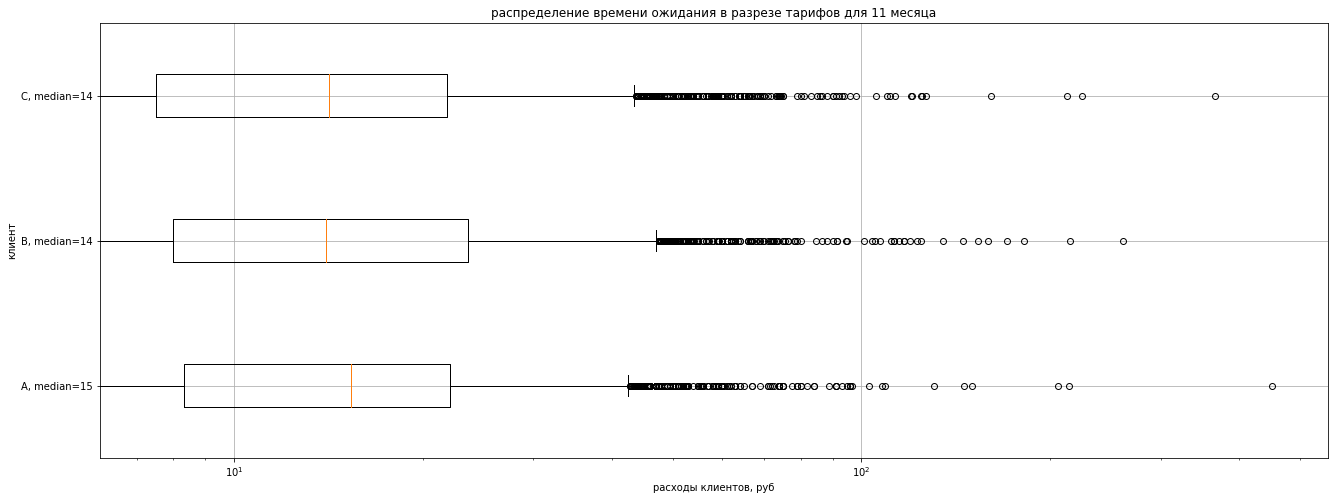

In [74]:
boxplot_sum_stroy(
    df_full_data_active_client, 'tariff_plan' , 'month_count', df_full_data_active_client['month_count'].max()
    , 'waiting_time' 
    , 'распределение времени ожидания в разрезе тарифов для ' + str(df_full_data_active_client['month_count'].max()) + ' месяца'
    , log_scale=True
    )

Даное распределение дано по всем направлениям звонков (в конечном случае- всегда работаешь с людьми) и для всех операторов. Данное упрощение приняли в следствии экономии времени и, на первый взгляд, сомнительности  кардинального отличия результатов в разрезе динамики, и направления вызовов.

Как можем увидеть из графика имеются большое кол-во выбросов (возможно для работы с живыми людьми (не всегда есть возможность взять трубку) и не очень хорошо настроенным телефонным автоматом (при длительном времени ожидании идёт сброс звонка) - нормально иметь большие выбросы). В общем, форма распределения (при отбрасывании выбросов) похожа на нормальную (медианное значение близко к среднему - хорошо для определение меры) и медианное время ожидания близко у разных клиентов (с разными тарифными планами) - можем объяснить это тем- что все работают с живыми людьми и автоматической передачи данных по линиям голосовй связи (см какой-нибудь голосовой модем) в работе клиентов не привалирует. Ожидание в 15 секунд- нормальное ожидание для звонков

По данному признаку- все едины

# 4) поиск клиентов с неоптимальными тарифами   <a name="client_style"></a>


создадим рабочую таблицу с отфильтрованными данными: работать будем только по посленему месяцу (11). Так же сделаем просчёт сумм для всех клиентов с разными тарифами сравним с текущими тарифами

In [75]:
df_optimum_client = df_full_data[ df_full_data['month_count'] == df_full_data['month_count'].max()]

подготовили рабочее поле- можем начать работать

## 4.1) поиск клиентов с неоптимальными тарифами и расчёт возможных улучшений   <a name="client_search"></a>


In [76]:

df_client_optimal =searc_optimum_tarif(df_optimum_client , 'tariff_plan')
print('сумма выручки на текущем тарифе: {} руб/мес \nсумма выручки при оптимальных тарифах: {} руб/мес \nпадение: {} %'.format( 
    df_client_optimal['total_sum'].sum() 
    ,df_client_optimal['total_sum_optimum'].sum()  
    ,round(100*(df_client_optimal['total_sum'].sum() / df_client_optimal['total_sum_optimum'].sum() -1 ) , 1)
     ))
df_client_optimal.sample(4)


сумма выручки на текущем тарифе: 605041.9 руб/мес 
сумма выручки при оптимальных тарифах: 427050.6 руб/мес 
падение: 41.7 %


,user_id,tariff_plan,month_count,tarif_sum,operator_sum,call_sum,total_sum,tarif_sum_A,operator_sum_A,call_sum_A,total_sum_A,tarif_sum_B,operator_sum_B,call_sum_B,total_sum_B,tarif_sum_C,operator_sum_C,call_sum_C,total_sum_C,total_sum_optimum,have_optimum_tarif,optimum_tarif
70,167059,C,11,1000.0,500,0.0,1500.0,5000.0,500,0.0,5500.0,2000.0,500,0.0,2500.0,1000.0,500,0.0,1500.0,1500.0,False,C
132,167630,C,11,1000.0,100,94.5,1194.5,5000.0,100,54.0,5154.0,2000.0,100,67.5,2167.5,1000.0,100,94.5,1194.5,1194.5,False,C
29,166691,C,11,1000.0,200,160.3,1360.3,5000.0,200,91.6,5291.6,2000.0,200,114.5,2314.5,1000.0,200,160.3,1360.3,1360.3,False,C
191,168054,C,11,1000.0,200,0.0,1200.0,5000.0,200,0.0,5200.0,2000.0,200,0.0,2200.0,1000.0,200,0.0,1200.0,1200.0,False,C


In [77]:
print('соотношение "родных" тарифов, шт.:')
print(df_client_optimal['tariff_plan'].value_counts())
print('соотношение оптимальных тарифов, шт.:')
print(df_client_optimal['optimum_tarif'].value_counts())

соотношение "родных" тарифов, шт.:
C    131
B     86
A     28
Name: tariff_plan, dtype: int64
соотношение оптимальных тарифов, шт.:
C    239
B      5
A      1
Name: optimum_tarif, dtype: int64


приведём таблицу для улучшения клиентов:

In [78]:
df_client_optimal_rab = df_client_optimal[ df_client_optimal['have_optimum_tarif'] ==True ][['user_id','tariff_plan','optimum_tarif','total_sum','total_sum_optimum']]
df_client_optimal_rab['delta_total_sum_rub'] = df_client_optimal_rab['total_sum'] - df_client_optimal_rab['total_sum_optimum']
df_client_optimal_rab['delta_total_sum_%'] =  round(100* ( 1- df_client_optimal_rab['total_sum_optimum'] / df_client_optimal_rab['total_sum'] ) , 1)
df_client_optimal_rab

,user_id,tariff_plan,optimum_tarif,total_sum,total_sum_optimum,delta_total_sum_rub,delta_total_sum_%
0,166377,B,C,3052.5,2313.5,739.0,24.2
4,166406,B,C,2463.0,1568.2,894.8,36.3
5,166407,A,C,5843.6,1876.3,3967.3,67.9
6,166428,B,C,2100.0,1100.0,1000.0,47.6
8,166485,B,C,3782.5,3295.5,487.0,12.9
...,...,...,...,...,...,...,...
235,168500,B,C,2100.0,1100.0,1000.0,47.6
237,168562,B,C,2100.0,1100.0,1000.0,47.6
239,168579,B,C,2200.0,1200.0,1000.0,45.5
240,168583,B,C,2200.0,1200.0,1000.0,45.5


получили рабочую таблицу по направлениям улучшения условий клиентов. В следующем пункте рассмотрим её более подробно

## 4.2) предложения по минимизации падения выручки   <a name="revenue_safe"></a>


In [79]:
#df_client_optimal.sample(4)

In [80]:
print('сумма выручки на текущем тарифе: {} руб/мес \nсумма выручки при оптимальных тарифах: {} руб/мес \nпадение: {} %'.format( 
    df_client_optimal['total_sum'].sum() 
    ,df_client_optimal['total_sum_optimum'].sum()  
    ,round(100*(df_client_optimal['total_sum'].sum() / df_client_optimal['total_sum_optimum'].sum() -1 ) , 1)
     ))

graf_for_present = df_client_optimal[['total_sum', 'total_sum_optimum']]

сумма выручки на текущем тарифе: 605041.9 руб/мес 
сумма выручки при оптимальных тарифах: 427050.6 руб/мес 
падение: 41.7 %


В связи с тем, что мы работаем с юр лицами, то предлагать для конкретного лица полу- оптимальный тариф нет смысла и даже вредно (если клиенту сообщить, что он работает по неоптимальному варианту- то он сам сможет посчитать свои расхолды и выявить более оптимальный вариант, а т.к. мы сказали полу-правду - наша репутация будет "подмочена")

* Для уменьшения суммы падения выручки мы можем предложить клиентам за некое вознаграждение предоставлять отчёт об их тратах и возможностях по оптимизации, что в конечном случае даст нам репутационные доходы и сможет привлеч дополнительных клиентов (т.е. дополнительные доходы)

In [81]:
df_client_optimal['have_optimum_tarif'] = df_client_optimal['have_optimum_tarif'].astype('bool')
#df_client_optimal.info()
df_client_optimal.groupby('tariff_plan').agg({'user_id' : 'count' , 'have_optimum_tarif' : 'mean'}).rename(columns = {'user_id' : 'count_user_tarif' , 'have_optimum_tarif' : 'part_client_to_optimaze'})

,count_user_tarif,part_client_to_optimaze
tariff_plan,,
A,28,0.964286
B,86,0.976744
C,131,0.000000


как можем увидеть из таблицы выше группу клиентов с тарифом "С" (135 шт) опимизировать не надо, в то время, как группу "А" (30 шт) и "В"(96 шт) можно прооптимизировать почти в полном составе. Но учитывая, что нам жедательно как-то уменьшить свои потери (хотя-бы в будущем) то целесообразно предлагать оптиизацию не всем клиентам. 

* Как говорилось ранее: группа "А" вероятно - начинающие организации, которые хотят иметь бурный рост. Соответсвенно в дальнейшем они либо развалятся (что полностью нивелирует уменьшить наши потери от них (нет звонков-нет доходов (так же ка кнет и недополученных доходов), либо они смогут завоевать определённую долю рынка, и соответсвенно будут уже более стабильной и долгоиграющей компанией. В этом случае нам очень важна лояльность таких клиентов (превращение в долгосрочного партнёра), что на длинной дистанции сможет нам покрыть упущенную выгоду понесённую в данный момент. Для расчёта дистанции- необхдимо провести исследование по динамике появления и оттока клиентов в разрезе их развития.

ниже покажем упущенную вгоду, если оптимизировать только группу "А"

In [82]:
df_client_optimal['search_sum'] = df_client_optimal['total_sum']
df_client_optimal.loc[ (df_client_optimal['tariff_plan'] == 'A') & (df_client_optimal['have_optimum_tarif'] == True) , 'search_sum'] = df_client_optimal['total_sum_optimum']

print('сумма выручки на текущем тарифе: {} руб/мес \nсумма выручки при оптимизированных(для группы А) тарифах: {} руб/мес \nпадение: {} %'.format( 
    df_client_optimal['total_sum'].sum() 
    ,df_client_optimal['search_sum'].sum()  
    ,round(100*(df_client_optimal['total_sum'].sum() / df_client_optimal['search_sum'].sum() -1 ) , 1)
     ))

graf_for_present['search_sum'] = df_client_optimal['search_sum']

сумма выручки на текущем тарифе: 605041.9 руб/мес 
сумма выручки при оптимизированных(для группы А) тарифах: 505236.0 руб/мес 
падение: 19.8 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


В случае оптимизации только по группе "А" мы потеряем только 19% мгновеенной выручки, в то время как при полной оптимизации- мы теряем 42% выручки

# 5) проверка гипотез   <a name="gipotes_start"></a>




In [83]:
#df_client_optimal.sample(3)

При проверке гипотез будем считать, что клиенты независимы друг от друга и не пользуются услугами друг друга по отношению к предаставляемыми нами услугами. Уровень доверия (альфа) примем общепризнаным (95%), т.к. нас в конечном счёте интересуют достаточно-точные предсказания (отброси уровень доверия 68%), но стремится к уровю доверия, используемому при принятии решений в задачах с высокой ответственностью (например, медицина) не будем (отбросим уровень доверия 99%)

In [84]:
alpha = 0.05

## 5.1) при оптимизации тарифов в пользу клиентов выручка уменьшится   <a name="gipotes_revenue_minimaze"></a>



Для сравнения будем испольщовать ttest для зависимых выборок (т.к. мы применяем изменения к самой выборке)
* Нулевая гипотеза (H0)- средние значения выручки по тарифам до оптимизации тарифов и после оптимизации равны
* Альтернативная гипотеза (Н1)- средние значения выручки различаются после проведения оптимизации

In [85]:
result_1 = st.ttest_rel(
    df_client_optimal['total_sum']
    , df_client_optimal['total_sum_optimum']
)

print('p-значение: ', result_1.pvalue )

if result_1.pvalue < alpha:
  print('у выборок есть стат различие. Принимаем гипотезу Н1')
else:
  print('у выборок нет статистички значимого различия при уровне доверия Р=95%')

p-значение:  1.137469339861597e-19
у выборок есть стат различие. Принимаем гипотезу Н1


Как показал ттест - есть различия в доходе. Как показали исследования выше- при оптимизации тарифов- итоговая Наша выручка падает. Впринципе, ожидаемый результат

## 5.2) распределения направлений звонков между группами отличаются   <a name="gipotes_cals_back"></a>



In [86]:
#df_full_data_active_client.sample(3)

Для сравнения будем испольщовать ztest  (т.к. мы работаем с бимодальным распределением)
* Нулевая гипотеза (H0)- направления звонков похожи у разных групп у нашй выборки клиентов в 11 месяце
* Альтернативная гипотеза (Н1)- направления звонков различаются у разных групп у нашй выборки клиентов в 11 месяце

In [87]:
#подготовим рабочую таблицу
df_full_data_active_client_rab = df_full_data_active_client.copy()
df_full_data_active_client_rab = df_full_data_active_client_rab[ df_full_data_active_client_rab['month_count'] == 11 ]
df_full_data_active_client_rab.loc[ df_full_data_active_client_rab['direction'] == 'in' , 'direction' ] = 1
df_full_data_active_client_rab.loc[ df_full_data_active_client_rab['direction'] == 'out' , 'direction' ] = 0

#df_full_data_active_client_rab.sample(5)

In [88]:
print('\nсравниваем клиентов с тарифами "А" и "В":')
result_2_A_B = ztest(
    df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'A' ]['direction']
    , df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'B' ]['direction']
    ,
)

print('p-значение: ', result_2_A_B[1] )

if result_2_A_B[1] < alpha:
  print('у выборок есть стат различие. Принимаем гипотезу Н1')
else:
  print('у выборок нет статистички значимого различия при уровне доверия Р=95%')

print('доля входящих для А:', round(df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'A' ]['direction'].mean(), 2))
print('доля входящих для B:', round(df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'B' ]['direction'].mean(), 2))

print('\nсравниваем клиентов с тарифами "А" и "С":')
result_2_A_C = ztest(
    df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'A' ]['direction']
    , df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'C' ]['direction']
    ,
)
print('p-значение: ', result_2_A_C[1] )

if result_2_A_C[1] < alpha:
  print('у выборок есть стат различие. Принимаем гипотезу Н1')
else:
  print('у выборок нет статистички значимого различия при уровне доверия Р=95%')

print('доля входящих для А:', round(df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'A' ]['direction'].mean(), 2))
print('доля входящих для C:', round(df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'C' ]['direction'].mean(), 2))



print('\nсравниваем клиентов с тарифами "C" и "В":')
result_2_C_B = ztest(
    df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'C' ]['direction']
    , df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'B' ]['direction']
    ,
)

print('p-значение: ', result_2_C_B[1] )

if result_2_C_B[1] < alpha:
  print('у выборок есть стат различие. Принимаем гипотезу Н1')
else:
  print('у выборок нет статистички значимого различия при уровне доверия Р=95%')

print('доля входящих для C:', round(df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'C' ]['direction'].mean(), 2))
print('доля входящих для B:', round(df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'B' ]['direction'].mean(), 2))



сравниваем клиентов с тарифами "А" и "В":
p-значение:  2.0749268655153674e-32
у выборок есть стат различие. Принимаем гипотезу Н1
доля входящих для А: 0.33
доля входящих для B: 0.42

сравниваем клиентов с тарифами "А" и "С":
p-значение:  8.748051648867755e-84
у выборок есть стат различие. Принимаем гипотезу Н1
доля входящих для А: 0.33
доля входящих для C: 0.48

сравниваем клиентов с тарифами "C" и "В":
p-значение:  2.380544348925146e-13
у выборок есть стат различие. Принимаем гипотезу Н1
доля входящих для C: 0.48
доля входящих для B: 0.42


можем сказать что направление звонков у клиентов с разными тарифами отличается. Данный факт можно учесть при расчёте рентабильности тарифа и при постраении новых тарифов

## 5.3) сравнение доминирующих операторов по группам   <a name="gipotes_operator"></a>



In [89]:
#df_full_data_active_client.sample(3)

для сравнения частот выпадания операторов- воспользуемся непараметрическим тестом. В качестве алгоритма возьмём тест Манна-Уитни. 

подготовим данные для сравнения (сравнение делаем тлько по 11 месяцу):

Для сравнения будем испольщовать  mannwhitneyu test  (т.к. мы работаем с частотным выпадением значений)
* Нулевая гипотеза (H0)- распределение по используемым операторам похожи у разных групп у нашей выборки клиентов в 11 месяце
* Альтернативная гипотеза (Н1)- распределение по используемым операторам различаются у разных групп у нашй выборки клиентов в 11 месяце

In [90]:
#подготовим рабочую таблицу
df_full_data_active_client_rab_2 = df_full_data_active_client.copy()
df_full_data_active_client_rab_2 = df_full_data_active_client_rab_2[ df_full_data_active_client_rab_2['month_count'] == 11 ]

#поменяем тип у столбца с номером оператора (чтобы алгоритм не взял их за числовые значения и отработал по частотной хар-ке)
df_full_data_active_client_rab_2['operator_id'] = df_full_data_active_client_rab_2['operator_id'].astype('object')

#df_full_data_active_client_rab_2.info()

In [91]:
print('\nсравниваем клиентов с тарифами "А" и "В":')
reult_3_A_B = mannwhitneyu(
    df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'A' ]['operator_id']
    , df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'B' ]['operator_id']
    , alternative =  'two-sided'
)

print('p-значение: ', reult_3_A_B.pvalue )

if reult_3_A_B.pvalue < alpha:
  print('у выборок есть стат различие. Принимаем гипотезу Н1')
else:
  print('у выборок нет статистички значимого различия при уровне доверия Р=95%')

print('\nсравниваем клиентов с тарифами "А" и "C":')
reult_3_A_C = mannwhitneyu(
    df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'A' ]['operator_id']
    , df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'C' ]['operator_id']
    , alternative =  'two-sided'
)

print('p-значение: ', reult_3_A_C.pvalue )

if reult_3_A_C.pvalue < alpha:
  print('у выборок есть стат различие. Принимаем гипотезу Н1')
else:
  print('у выборок нет статистички значимого различия при уровне доверия Р=95%')

print('\nсравниваем клиентов с тарифами "C" и "В":')
reult_3_C_B = mannwhitneyu(
    df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'C' ]['operator_id']
    , df_full_data_active_client_rab[ df_full_data_active_client_rab['tariff_plan'] == 'B' ]['operator_id']
    , alternative =  'two-sided'
)

print('p-значение: ', reult_3_C_B.pvalue )

if reult_3_C_B.pvalue < alpha:
  print('у выборок есть стат различие. Принимаем гипотезу Н1')
else:
  print('у выборок нет статистички значимого различия при уровне доверия Р=95%')


сравниваем клиентов с тарифами "А" и "В":
p-значение:  1.4828483166946804e-229
у выборок есть стат различие. Принимаем гипотезу Н1

сравниваем клиентов с тарифами "А" и "C":
p-значение:  3.09260242853878e-287
у выборок есть стат различие. Принимаем гипотезу Н1

сравниваем клиентов с тарифами "C" и "В":
p-значение:  0.0006967176810883302
у выборок есть стат различие. Принимаем гипотезу Н1


как можем увидеть- распределения по исользуемым операторам у разных групп отличаются. При необходимости оптимизации работ с операторами, можно провести дополнительное исследование и несколько оптимизировать расходы на сотрудничество с операторами

# выводы  <a name="concusions"></a>



In [92]:
print('сумма выручки на текущем тарифе: {} руб/мес \nсумма выручки при оптимальных тарифах: {} руб/мес \nпадение: {} %'.format( 
    df_client_optimal['total_sum'].sum() 
    ,df_client_optimal['total_sum_optimum'].sum()  
    ,round(100*(df_client_optimal['total_sum'].sum() / df_client_optimal['total_sum_optimum'].sum() -1 ) , 1)
     ))


сумма выручки на текущем тарифе: 605041.9 руб/мес 
сумма выручки при оптимальных тарифах: 427050.6 руб/мес 
падение: 41.7 %


In [93]:
print('сумма выручки на текущем тарифе: {} руб/мес \nсумма выручки при оптимизированных(для группы А) тарифах: {} руб/мес \nпадение: {} %'.format( 
    df_client_optimal['total_sum'].sum() 
    ,df_client_optimal['search_sum'].sum()  
    ,round(100*(df_client_optimal['total_sum'].sum() / df_client_optimal['search_sum'].sum() -1 ) , 1)
     ))

сумма выручки на текущем тарифе: 605041.9 руб/мес 
сумма выручки при оптимизированных(для группы А) тарифах: 505236.0 руб/мес 
падение: 19.8 %


In [94]:
print('медианная абсолютная стоимость минуты разговора для клиентов в разрезе тарифов:')
df_rab_rab['rub/min'].to_frame()

медианная абсолютная стоимость минуты разговора для клиентов в разрезе тарифов:


,rub/min
tariff_plan,
A,66.709756
B,49.661290
C,40.000000



В связи с тем, что мы работаем с юр лицами, то предлагать для конкретного лица полу- оптимальный тариф нет смысла и даже вредно (если клиенту сообщить, что он работает по неоптимальному варианту- то он сам сможет посчитать свои расхолды и выявить более оптимальный вариант, а т.к. мы сказали полу-правду - наша репутация будет "подмочена")
* Для уменьшения суммы падения выручки мы можем предложить клиентам за некое вознаграждение предоставлять отчёт об их тратах и возможностях по оптимизации, что в конечном случае даст нам репутационные доходы и сможет привлеч дополнительных клиентов (т.е. дополнительные доходы)

* группа "А" вероятно - начинающие организации, которые хотят иметь бурный рост. Соответсвенно в дальнейшем они либо развалятся (что полностью нивелирует уменьшить наши потери от них (нет звонков-нет доходов (так же ка кнет и недополученных доходов), либо они смогут завоевать определённую долю рынка, и соответсвенно будут уже более стабильной и долгоиграющей компанией. В этом случае нам очень важна лояльность таких клиентов (превращение в долгосрочного партнёра), что на длинной дистанции сможет нам покрыть упущенную выгоду понесённую в данный момент.



так же получили список всех клиентов (по 11 месяцу) которым можно предложить оптимизацию


In [95]:
df_client_optimal_rab.head()

,user_id,tariff_plan,optimum_tarif,total_sum,total_sum_optimum,delta_total_sum_rub,delta_total_sum_%
0,166377,B,C,3052.5,2313.5,739.0,24.2
4,166406,B,C,2463.0,1568.2,894.8,36.3
5,166407,A,C,5843.6,1876.3,3967.3,67.9
6,166428,B,C,2100.0,1100.0,1000.0,47.6
8,166485,B,C,3782.5,3295.5,487.0,12.9


Можем предположить, что самый перспективный для развития отношений клиент с тарифом "А" - начинающее малое предприятие с потенциалом к росту

В среднем клиент "А" приносит больше денег чем остальные клиенты, при этом это самая малочисленная группа. Большинство клиентов работают с людьми (судя по времени ожидания звонков), а не в автоматизированных системах

#алгоритм для авто расчёта  <a name="auto_algo"></a>




на вход применяются только очищенные и поготовленные данные

* отделение активных клиентов производится ф-цией active_client_detector
* построение графика выручки в разрезе тарифов строим ф-цией boxplot_sum_stroy, а динамику изменения суммарного дохода по месяцам в разрезе групп: boxplot_sum_story_stroy 
* распределение времени ожидания в разрезе тарифов строится ф-ций boxplot_sum_stroy
* поиск отимума для клиентов ищем ф-цией searc_optimum_tarif



выгрузим подготовленные данные для размещения их в Tableau Public:


In [96]:
try:
    from google.colab import files
    df_full_data_active_client.to_csv('da_23_telecom_data_for_tableau.csv')
    files.download('da_23_telecom_data_for_tableau.csv')
except:
    print('не та среда...')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [97]:
#df_full_data_active_client.sample(3)

In [98]:
(df_full_data_active_client.groupby('direction').agg(
    как_на_дашборде = ('calls_count','count'), а_на_самом_деле = ('calls_count','sum')).reset_index())

,direction,как_на_дашборде,а_на_самом_деле
0,in,19753,169684
1,out,26653,501498


графики для презентации

In [99]:
graf_for_present.sum()

total_sum            605041.9
total_sum_optimum    427050.6
search_sum           505236.0
dtype: float64

In [100]:
graf_for_present.sample()

,total_sum,total_sum_optimum,search_sum
30,1100.0,1100.0,1100.0


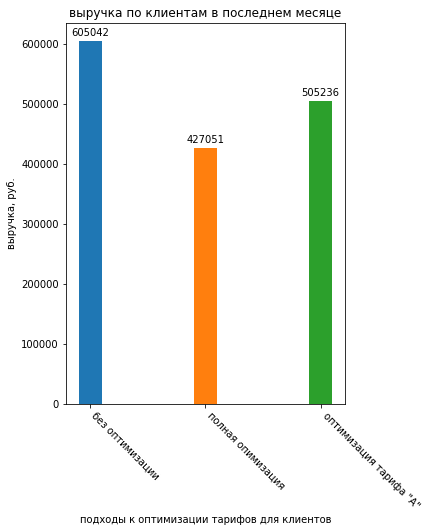

In [101]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,7))

ax.set_title('выручка по клиентам в последнем месяце' )
ax.bar(x= 'без оптимизации' , height= round(graf_for_present['total_sum'].sum()), width =0.2, label='оставшиеся клиенты', align='center', )
ax.bar(x= 'полная опимизация' , height= round(graf_for_present['total_sum_optimum'].sum()), width =0.2, label='оставшиеся клиенты', align='center', )
ax.bar(x= 'оптимизация тарифа "А"' , height= round(graf_for_present['search_sum'].sum()), width =0.2, label='оставшиеся клиенты', align='center', )
#ax.bar(x= df_rab_2.index.astype('str') , height= df_rab_2['1'], width =0.2, label='ушедшие клиенты', align='edge',)

ax.set_xlabel('подходы к оптимизации тарифов для клиентов')
ax.set_ylabel('выручка, руб.')

#ax.grid()

#ax.legend(loc = locus)

plt.xticks(rotation=-45, ha='left')

for bar in ax.patches:
  ax.annotate(bar.get_height(), 
                (bar.get_x() + bar.get_width() / 2, 
                  bar.get_height()), ha='center', va='center',
                size=10, xytext=(0, 8),
                textcoords='offset points')

plt.show()

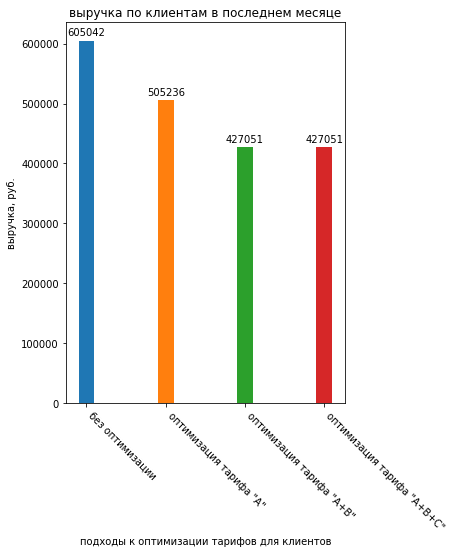

In [102]:
df_client_optimal['search_sum'] = df_client_optimal['total_sum']
df_client_optimal.loc[ (df_client_optimal['tariff_plan'] == 'A') & (df_client_optimal['have_optimum_tarif'] == True) , 'search_sum'] = df_client_optimal['total_sum_optimum']

df_client_optimal['search_sum_B'] = df_client_optimal['total_sum']
df_client_optimal.loc[ (df_client_optimal['tariff_plan'] == 'B') & (df_client_optimal['have_optimum_tarif'] == True) , 'search_sum_B'] = df_client_optimal['total_sum_optimum']
df_client_optimal.loc[ (df_client_optimal['tariff_plan'] == 'A') & (df_client_optimal['have_optimum_tarif'] == True) , 'search_sum_B']= df_client_optimal['total_sum_optimum']

df_client_optimal['search_sum_C'] = df_client_optimal['total_sum']
df_client_optimal.loc[ (df_client_optimal['tariff_plan'] == 'C') & (df_client_optimal['have_optimum_tarif'] == True) , 'search_sum_C'] = df_client_optimal['total_sum_optimum']
df_client_optimal.loc[ (df_client_optimal['tariff_plan'] == 'B') & (df_client_optimal['have_optimum_tarif'] == True) , 'search_sum_C'] = df_client_optimal['total_sum_optimum']
df_client_optimal.loc[ (df_client_optimal['tariff_plan'] == 'A') & (df_client_optimal['have_optimum_tarif'] == True) , 'search_sum_C']= df_client_optimal['total_sum_optimum']



fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,7))

ax.set_title('выручка по клиентам в последнем месяце' )
ax.bar(x= 'без оптимизации' , height= round(df_client_optimal['total_sum'].sum()), width =0.2, label='оставшиеся клиенты', align='center', )
ax.bar(x= 'оптимизация тарифа "А"' , height= round(graf_for_present['search_sum'].sum()), width =0.2, label='оставшиеся клиенты', align='center', )
ax.bar(x= 'оптимизация тарифа "A+B"' , height= round(df_client_optimal['search_sum_B'].sum()), width =0.2, label='оставшиеся клиенты', align='center', )
ax.bar(x= 'оптимизация тарифа "A+B+C"' , height= round(df_client_optimal['search_sum_C'].sum()), width =0.2, label='оставшиеся клиенты', align='center', )

#ax.bar(x= df_rab_2.index.astype('str') , height= df_rab_2['1'], width =0.2, label='ушедшие клиенты', align='edge',)

ax.set_xlabel('подходы к оптимизации тарифов для клиентов')
ax.set_ylabel('выручка, руб.')

#ax.grid()

#ax.legend(loc = locus)

plt.xticks(rotation=-45, ha='left')

for bar in ax.patches:
  ax.annotate(bar.get_height(), 
                (bar.get_x() + bar.get_width() / 2, 
                  bar.get_height()), ha='center', va='center',
                size=10, xytext=(0, 8),
                textcoords='offset points')

plt.show()

In [103]:
df_client_optimal.sample()

,user_id,tariff_plan,month_count,tarif_sum,operator_sum,call_sum,total_sum,tarif_sum_A,operator_sum_A,call_sum_A,total_sum_A,tarif_sum_B,operator_sum_B,call_sum_B,total_sum_B,tarif_sum_C,operator_sum_C,call_sum_C,total_sum_C,total_sum_optimum,have_optimum_tarif,optimum_tarif,search_sum,search_sum_B,search_sum_C
142,167727,C,11,1000.0,100,1380.4,2480.4,5000.0,100,788.8,5888.8,2000.0,100,986.0,3086.0,1000.0,100,1380.4,2480.4,2480.4,False,C,2480.4,2480.4,2480.4


In [104]:
df_client_optimal.groupby(['tariff_plan','have_optimum_tarif'])['user_id'].count()

tariff_plan  have_optimum_tarif
A            False                   1
             True                   27
B            False                   2
             True                   84
C            False                 131
Name: user_id, dtype: int64